<a href="https://colab.research.google.com/github/rtealwitter/dl-demos/blob/main/demo01_basics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## PyTorch Basics

Today, we'll start by going through a small variable exercise to get familiarity with `pytorch`. I will assume that you are already comfortable with python and `numpy`. If that's not the case, there are many wonderful resources online that I can direct you towards.

Once we have a working understanding of `pytorch`, we'll go through a real example of training a neural network on a non-trivial task of recognizing handwritten digits.

After watching the demo, I want you to:

* understand `pytorch` variables,

* realize that `pytorch` keeps track of *how* variables are computed,

* have a working familiarity with loading training data in `pytorch`,

* have cursory skills to investigate a new data set,

* get a first look at how to define a "deep" learning model,

* get a first look at how to train a model in `pytorch`.

There's a lot going on under the hood that we'll learn about in the lectures. For this demo in particular, we won't yet have a firm grasp of *how* the training works but we will get there soon!

The demos are more fun for me and helpful for you if you ask lots of questions :)


### Practice with `numpy` and `pytorch`!

In [1]:
# We'll start by importing some libraries
import numpy as np # Very helpful (and popular!) for mathematical computation
import torch # The main deep learning library we'll use (there are others...)
import torchvision # Specialized for vision tasks such as recognizing digits
import matplotlib.pyplot as plt # Helpful for plotting things (like our images!)

Let's start off by seeing the relationship between `numpy` and `pytorch`.

In [2]:
a = np.random.rand(2,3) # Build a random 2x3 matrix in numpy
b = torch.from_numpy(a) # Convert a to a "tensor" (variable in pytorch)

print(a)
print(b)

[[0.09053868 0.87674874 0.1798714 ]
 [0.42330723 0.65401394 0.66165931]]
tensor([[0.0905, 0.8767, 0.1799],
        [0.4233, 0.6540, 0.6617]], dtype=torch.float64)


We can see that the `numpy` matrix and `pytorch` tensor both encode the same matrix. The `pytorch` librariy believes that everything is a tensor.

The main benefit is that tensors allow for intuitive and efficient matrix multiplication across different indexing dimensions. Soon, we will see that trianing neural nets basically consists of *forward* and *backward* passes, both of which use matrix multiplication as the core subroutine.

The other benefit of tensors is that they can easily be differentiated. Again, we'll see why this is important when we learn about backpropagation.

For now, let's run through a series of computations with `a`.

In [3]:
new_a = a + 10 # Add 10 to every entry in a
print(new_a)

new_a = new_a**2 # Square every entry in a
print(new_a)

new_a = new_a.sum() # Take the sum of all the entries
print(new_a)

[[10.09053868 10.87674874 10.1798714 ]
 [10.42330723 10.65401394 10.66165931]]
[[101.81897089 118.30366314 103.62978182]
 [108.64533352 113.50801307 113.6709792 ]]
659.5767416400093


Let's compare this to what happens when do the same operations on `b` but keep track of the history with `requires_grad=True`.

In [4]:
new_b = b.requires_grad_() # Start keeping track of computation history

new_b = new_b + 10
print(new_b)

new_b = new_b ** 2
print(new_b)

new_b = new_b.sum()
print(new_b)

tensor([[10.0905, 10.8767, 10.1799],
        [10.4233, 10.6540, 10.6617]], dtype=torch.float64,
       grad_fn=<AddBackward0>)
tensor([[101.8190, 118.3037, 103.6298],
        [108.6453, 113.5080, 113.6710]], dtype=torch.float64,
       grad_fn=<PowBackward0>)
tensor(659.5767, dtype=torch.float64, grad_fn=<SumBackward0>)


All of the outputs are the same for `new_a` and `new_b`. However, there's a new variable in the output `grad_fn` which describes the *type* of operation we performed on `new_b` last. This is very helpful for taking the derivative (the key primitive of gradient descent which we'll learn about soon).

Let's see how we can use this to compute the derivative. We'll define $x$ and $y$ as random numbers and compute $z = x^2 y$. Now we know from calculus that $dz/dx = 2x y$. Can we use tensors to get that answer?

In [5]:
y = torch.rand(1,1) # Initialize a random 1x1 matrix (a number)
x = torch.rand(1,1, requires_grad=True) # Keep track of the gradient of x
z = x**2 * y
print('x:', x)
print('y:', y)
print('z:', z)
z.backward() # Compute the gradient of z with respect to its "descendants"
print('dz/dx:', x.grad) # The gradient we computed
print('dz/da:', 2 * x * y) # The gradient we know analytically

x: tensor([[0.2249]], requires_grad=True)
y: tensor([[0.1940]])
z: tensor([[0.0098]], grad_fn=<MulBackward0>)
dz/dx: tensor([[0.0873]])
dz/da: tensor([[0.0873]], grad_fn=<MulBackward0>)


It works! The gradient according to `pytorch` is the same we know is true from calculus. Of course, we'll be working in more than one dimension. Let's try the same example but with slightly larger vectors.

Now, $X \in \mathbb{R}^{2 \times 2}$, $Y \in \mathbb{R}^2$, and $z=\textrm{sum}(X^2 Y)$.

The partial derivative $\nabla_X z= $

In [6]:
Y = torch.rand(2,1) # Initialize a random 2x1 matrix (a number)
X = torch.rand(2,2, requires_grad=True) # Keep track of the gradient of x
z = (X**2 * Y).sum()
print('X:', X)
print('Y:', Y)
print('z:', z)
z.backward() # Compute the gradient of z with respect to its "descendants"
print('dz/dX$:', X.grad) # The gradient we computed
print('dz/dX$:', 2 * X * Y) # The gradient we know analytically

X: tensor([[0.6926, 0.0327],
        [0.5490, 0.2185]], requires_grad=True)
Y: tensor([[0.6337],
        [0.8532]])
z: tensor(0.6026, grad_fn=<SumBackward0>)
dz/dX$: tensor([[0.8778, 0.0414],
        [0.9369, 0.3728]])
dz/dX$: tensor([[0.8778, 0.0414],
        [0.9369, 0.3728]], grad_fn=<MulBackward0>)


Again, it works! If your vector calculus is a little rusty, that's okay since we'll be practicing.

### Real "Deep" Learning!!

Let's jump in with our first model. We will train a logistic classifier (equivalent to a single-layer network with cross entropy loss). The task is to classify images in the popular MNIST data set.

We don't yet have the full background to understand everything that's going on. That's okay. The goal is to give you a first look at how we do deep learning.

We'll begin by loading the data set.

In [7]:
# We won't go into the specifics of these function calls just yet.
trainingdata = torchvision.datasets.MNIST('./MNIST/',train=True,download=True,transform=torchvision.transforms.ToTensor())
testdata = torchvision.datasets.MNIST('./MNIST/',train=False,download=True,transform=torchvision.transforms.ToTensor())

100%|██████████| 9912422/9912422 [00:00<00:00, 114039468.76it/s]

Extracting ./MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 114278956.44it/s]

Extracting ./MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 26626003.48it/s]


Extracting ./MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 23577387.09it/s]

Extracting ./MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw



Let's take a look at how much training and test data we have.

In [8]:
print(f'There are {len(trainingdata)} training images.')
print(f'There are {len(testdata)} test images.')

There are 60000 training images.
There are 10000 test images.


That's a lot! But perfect for our favorite big data, deep learning setting. Let's look inside to see one of these examples.

In [9]:
image, label = trainingdata[0]
print(image.shape) # A 1x28x28 image. This means one color and on a grid of 28x28 pixels.
print(label) # A single number corresponding to the label of this image.

torch.Size([1, 28, 28])
5


We can't directly plot the image because of formatting constraints that the first dimension can't have a size of 1. Instead, we'll use the `squeeze` function to turn it into a 28x28 image that we can plot.

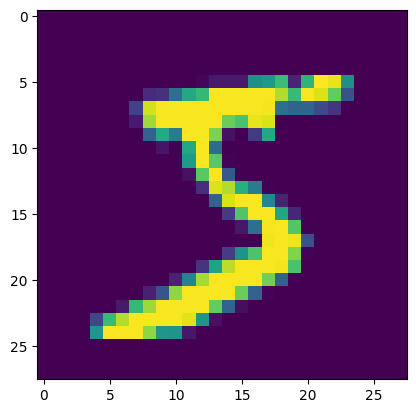

In [10]:
plt.imshow(image.squeeze()) # Plot the 28x28 image
plt.show()

What does that look like to you? Maybe a 5?

We'll see if the neural network can learn it. But first, let's define a handy way of loading the data.

In [11]:
# The DataLoader is a nifty class for wrapping the data so we can load batches easily
trainDataLoader = torch.utils.data.DataLoader(trainingdata,batch_size=64,shuffle=True)
testDataLoader = torch.utils.data.DataLoader(testdata,batch_size=64,shuffle=False)

images, labels = next(iter(trainDataLoader)) # Let's take a look at an example batch
print(images.shape) # There are 64 images
print(labels.shape) # And the corresponding 64 labels

torch.Size([64, 1, 28, 28])
torch.Size([64])


We loaded a batch with 64 images and labels. Let's say we wanted to do a batch of 128, how would you accomplish that by modifying the code above?

Now that we have our data, let's define our model, loss function, and optimizer using our three step recipe for machine learning.

In [36]:
# We write this in the standard python class format
class Model(torch.nn.Module):
  def __init__(self): # This runs whenever we initialize a new model
    super(Model, self).__init__()
    self.linear = torch.nn.Linear(28*28, 10)
    # We define a layer with input size 28*28 and output 10

  def forward(self, x): # This runs when we call the model on x
    x = x.view(-1, 28*28) # Change from 28x28 view to 784 vector
    x = self.linear(x) # Pass x through the linear layer
    return x

# Step 1: Model
model = Model() # Use the class we just defined
# Step 2: Loss
loss = torch.nn.CrossEntropyLoss()
# Step 3: Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.01) # Use stochastic gradient descent on the weights in the model



We also want to run everything quickly on a GPU. A GPU enables us to (basically) to matrix multiplication fast.

In [37]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'We\'re using the {device}.')
# Put the model on the device
model = model.to(device)

We're using the cuda.


Now let's do some training!! We'll treat the training process as a bit of a black box for now.

As we go, we'll keep track of the training and test loss so we can visualize how they change later.

In [38]:
train_losses = []
test_losses = []

for epoch in range(5): # We'll train for 5 "epochs"
  train_loss = 0
  test_loss = 0

  # Evaluation process
  for i, data in enumerate(testDataLoader):
    images, labels = data # Unpack the data into the images and labels
    images, labels = images.to(device), labels.to(device) # Put on device
    predicted_output = model(images) # Apply our network to the images
    fit = loss(predicted_output, labels) # Measure how well the predicted output matches the labels
    test_loss += fit.item() # Add the fit to the loss for tracking purposes

  # Training process
  for i, data in enumerate(trainDataLoader):
    images, labels = data # Unpack the data into the images and labels
    images, labels = images.to(device), labels.to(device) # Put on device
    optimizer.zero_grad() # Zero out the gradient values
    predicted_output = model(images) # Apply our network to the images
    fit = loss(predicted_output, labels) # Measure how well the predicted output matches the labels
    fit.backward() # Compute the gradient of the fit with respect to the model parameters
    optimizer.step() # Update the weights in the model using gradient descent
    train_loss += fit.item() # Add the fit to the loss for tracking purposes

  # Add the current losses to our tracking lists
  train_losses += [train_loss/len(trainDataLoader)]
  test_losses += [test_loss/len(testDataLoader)]

  # Print the current loss
  print(f'Epoch {epoch}, Train loss {train_loss}, Test loss {test_loss}')

Epoch 0, Train loss 920.0377095937729, Test loss 365.5077087879181
Epoch 1, Train loss 516.9119004905224, Test loss 94.10491648316383
Epoch 2, Train loss 442.2295154482126, Test loss 74.57143542170525
Epoch 3, Train loss 405.6883602440357, Test loss 66.74878649413586
Epoch 4, Train loss 383.1943348944187, Test loss 62.2986721098423


Let's plot our loss by training epoch to see how we did over time.

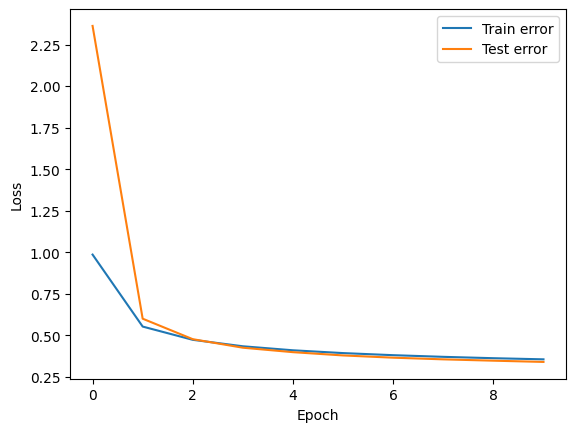

In [33]:
plt.plot(range(5),train_losses, label='Train error')
plt.plot(range(5),test_losses, label='Test error')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

The test loss is always larger than the training loss. Why is that?

Let's look at an example to see how well the model does. We'll use the variables from the last pass of the training process.

In [34]:
predicted_classes = torch.max(predicted_output, 1)[1]
print('Predicted:', predicted_classes)
print('Labels:', labels)


Predicted: tensor([5, 4, 7, 9, 1, 6, 9, 0, 9, 6, 6, 7, 3, 9, 0, 6, 8, 3, 9, 6, 3, 4, 1, 1,
        9, 8, 1, 3, 1, 1, 5, 8], device='cuda:0')
Labels: tensor([5, 4, 7, 9, 1, 6, 9, 0, 9, 6, 6, 7, 3, 9, 0, 6, 8, 3, 9, 6, 3, 4, 1, 1,
        4, 8, 1, 3, 1, 1, 5, 9], device='cuda:0')


Predicted: 4
Labels: 4


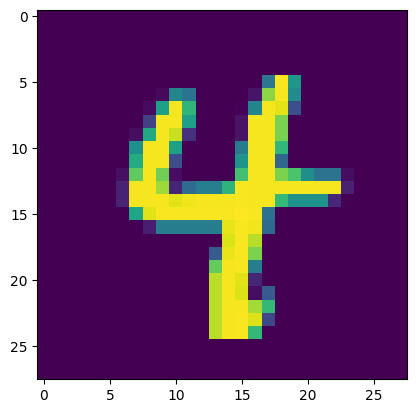

In [35]:
i = 1
print('Predicted:', predicted_classes[i].item())
print('Labels:', labels[i].item())
plt.imshow(images[i].squeeze().cpu()) # Visualize iamge
plt.show()